# Introducere


Scopul invatarii automate
- crearea unei legaturi intre date (date de intrare si date de iesire, date cunoscute si date necunoascute)

Cum?
- cu ajutorul unui program1 menit sa antreneze un alt program2 (numit model de predictie) care va procesa informatiile propriu-zise (numite date de antrenament)
- dupa antrenare, programul2 (modelul) va prelua date si va furniza rezultate (predictii)

Invatarea automata
- supervizata - atunci cand datele de antrenament sunt etichetate (= date de intrare cunoscute, date de iesire cunoscute)
- nesupervizata - atunci cand datele de antrenament nu sunt etichetate (= date de intrare cunoscute, date de iesire necunoscute, dar exista unele informatii despre acestea)

Pasi importanti in dezvoltarea unui proiect de invatare automata
1. definirea problemei in terminologia invatarii automate
2. colectarea si pregatirea datelor
3. antrenarea unui model de predictie
4. utilizarea modelului de predictie 

# Exemplificare probleme de regresie

## Prerequisites



In [1]:
#@title run the code below to import the necessary dependencies 

import csv
import matplotlib.pyplot as plt 
import os
import io
import requests
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

  
def loadData(fileName, featureNames, outputVariabName):
    data = []
    dataNames = []
    csv_reader = csv.reader(fileName, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            dataNames = row
        else:
            data.append(row)
        line_count += 1
    inputs = []
    for i in range(len(data)):
        crtExample = []
        for feature in featureNames:
            selectedVariable = dataNames.index(feature)
            crtExample.append(data[i][selectedVariable])
        inputs.append(crtExample)
        
    selectedOutput = dataNames.index(outputVariabName)
    outputs = []
    for i in range(len(data)):
        outputs.append(data[i][selectedOutput])
    
    return inputs, outputs

def fromStringToNumericData(values):
    if isinstance(values[0], list):
        aux = []
        for i in range(len(values)):
            line = []
            for j in range(len(values[i])):
                line.append(float(values[i][j]))
            aux.append(line)
        return aux
    else:
        aux = []
        for i in range(len(values)):
            aux.append(float(values[i]))
        return aux

def getFeature(data, pos):
    values = []
    for i in range(len(data)):
        values.append(data[i][pos])
    return values

def plotData(inputData, outputData, inputNames, outputName):
    # a single feature
    if len(inputData[0]) == 1: 
        featureValues = [inputData[i][0] for i in range(len(inputData))]        
        fig = plt.plot(featureValues, outputData, 'ro') 
        plt.xlabel(inputNames[0])
        plt.ylabel(outputName)
        plt.title(outputName + ' for different ' + inputNames[0])
        plt.show()
    else:
        # two features
        if len(inputData[0]) == 2:
            featureValues1 = [inputData[i][0] for i in range(len(inputData))] 
            featureValues2 = [inputData[i][1] for i in range(len(inputData))]   
            from mpl_toolkits import mplot3d
            ax = plt.axes(projection = '3d')
            fig = plt.scatter(featureValues1, featureValues2, outputData, c = 'r', marker = 'o')
            ax.set_xlabel(inputNames[0])
            ax.set_ylabel(inputNames[1])
            ax.set_zlabel(outputName)
            plt.title(outputName + ' for different ' + inputNames[0] + ' and ' + inputNames[1])
            plt.show()
        else: 
            print('two many dimensions to be plotted...')
            
def plotHistograms(inputs, outputs):
    noFeatures = len(inputs[0])
    fig, ax = plt.subplots(1, noFeatures + 1,  figsize=(4 * (noFeatures + 1), 4))
    for i in range(noFeatures):
        crtFeatureValues = getFeature(inputs, i)
        ax[i].hist(crtFeatureValues, 10, color = 'r')
        ax[i].title.set_text('histogram of ' + featureNames[i])
    ax[noFeatures].hist(outputs, 10, color = 'g')
    ax[noFeatures].title.set_text('histogram of ' + outputName)

    plt.show()

def visualiseRegressor(regressor):
    modelString = 'the learnt model: f(x) = ' + str(regressor.intercept_) 
    for i in range(noFeatures):
        modelString = modelString + ' + ' + str(regressor.coef_[i]) + ' * x^' + str(i + 1)
    print(modelString)

def plotRegressor(regressor, inputs, outputs):
    # prepare some synthetic data (inputs are random, while the outputs are computed by the learnt model)
    noOfPoints = 500
    xref = []
    xvalues = getFeature(inputs, 0)
    val = min(xvalues)
    step = (max(xvalues) - min(xvalues)) / noOfPoints
    for i in range(1, noOfPoints):
        xref.append(val)
        val += step
    yref = [regressor.intercept_ + regressor.coef_[0] * el for el in xref] 

    plt.plot(inputs, outputs, 'ro', label = 'training data')  #train data are plotted by red and circle sign
    plt.plot(xref, yref, 'b-', label = 'learnt model')                  #model is plotted by a blue line
    plt.title('train data and the learnt model')
    plt.xlabel('temp')
    plt.ylabel('cnt')
    plt.legend()
    plt.show()

def plotClassificationData(inputs, outputs, featureNames):
    noExamples = len(inputs)
    labels = set(outputs)
    noData = len(inputs)
    for crtLabel in labels:
        x = [inputs[i][0] for i in range(noExamples) if outputs[i] == crtLabel ]
        y = [inputs[i][1] for i in range(noExamples) if outputs[i] == crtLabel ]
        plt.scatter(x, y, label = crtLabel)
    plt.xlabel(featureNames[0])
    plt.ylabel(featureNames[1])
    plt.legend()
    plt.show()  

def plotPredictions(feature1, feature2, realOutputs, computedOutputs, title, featureNames, labels):
    noData = len(feature1)
    for crtLabel in labels:
        x = [feature1[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] == crtLabel ]
        y = [feature2[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] == crtLabel]
        plt.scatter(x, y, label = crtLabel + ' (correct)')
    for crtLabel in labels:
        x = [feature1[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] != crtLabel ]
        y = [feature2[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] != crtLabel]
        plt.scatter(x, y, label = crtLabel + ' (incorrect)')
    plt.xlabel(featureNames[0])
    plt.ylabel(featureNames[1])
    plt.legend()
    plt.title(title)
    plt.show()

def countExamples(outputs):
    labels = list(set(outputs)).sort()
    distribution = {}
    for label in outputs:
        if label in distribution.keys():
            distribution[label] += 1
        else:
            distribution[label] = 1
    return distribution


def plotADecisionTree(clf):
  n_nodes = clf.tree_.node_count
  children_left = clf.tree_.children_left
  children_right = clf.tree_.children_right
  feature = clf.tree_.feature
  threshold = clf.tree_.threshold

  node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
  is_leaves = np.zeros(shape=n_nodes, dtype=bool)
  stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
  while len(stack) > 0:
      # `pop` ensures each node is only visited once
      node_id, depth = stack.pop()
      node_depth[node_id] = depth

      # If the left and right child of a node is not the same we have a split
      # node
      is_split_node = children_left[node_id] != children_right[node_id]
      # If a split node, append left and right children and depth to `stack`
      # so we can loop through them
      if is_split_node:
          stack.append((children_left[node_id], depth + 1))
          stack.append((children_right[node_id], depth + 1))
      else:
          is_leaves[node_id] = True

  # print("The binary tree structure has {n} nodes and has "
  #       "the following tree structure:\n".format(n=n_nodes))
  # for i in range(n_nodes):
  #     if is_leaves[i]:
  #         print("{space}node={node} is a leaf node.".format(
  #             space=node_depth[i] * "\t", node=i))
  #     else:
  #         print("{space}node={node} is a split node: "
  #               "go to node {left} if X[:, {feature}] <= {threshold} "
  #               "else to node {right}.".format(
  #                   space=node_depth[i] * "\t",
  #                   node=i,
  #                   left=children_left[i],
  #                   feature=feature[i],
  #                   threshold=threshold[i],
  #                   right=children_right[i]))
          
  tree.plot_tree(clf)
  plt.show()


def plotDataWithPredictions(inputData, outputData, computedOutputData, inputNames, outputName):
    # a single feature
    if len(inputData[0]) == 1: 
        featureValues = [inputData[i][0] for i in range(len(inputData))]        
        fig = plt.plot(featureValues, outputData, 'ro') 
        plt.plot(featureValues, computedOutputData, 'bo') 
        plt.xlabel(inputNames[0])
        plt.ylabel(outputName)
        plt.title(outputName + ' for different ' + inputNames[0])
        plt.show()
    else:
        # two features
        if len(inputData[0]) == 2:
            featureValues1 = [inputData[i][0] for i in range(len(inputData))] 
            featureValues2 = [inputData[i][1] for i in range(len(inputData))]   
            from mpl_toolkits import mplot3d
            ax = plt.axes(projection = '3d')
            fig = plt.scatter(featureValues1, featureValues2, outputData, c = 'r', marker = 'o')
            plt.scatter(featureValues1, featureValues2, computedOutputData, c = 'b', marker = 'o')
            ax.set_xlabel(inputNames[0])
            ax.set_ylabel(inputNames[1])
            ax.set_zlabel(outputName)
            plt.title(outputName + ' for different ' + inputNames[0] + ' and ' + inputNames[1])
            plt.show()
        else: 
            print('two many dimensions to be plotted...')

## Scenariul 1: predictia gradului de bunastare sociala pe baza PIB-ului 


Proces:
- Se pleaca de la un set de date format din date economico-sociale diverse culese pentru mai multe tari
- Se stabilesc variabile independente (PIB) si dependente (gradul de bunastare sociala)
- Se aplica algoritmul de invatare pe setul de date de antrenament
- Se realizeaza predictii ale gradului de bunastare sociala pentru noi valori ale PIB-ului

In [8]:
#@title run the code below to inspect the raw data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/world-happiness-report-2017.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

dataCrt = pd.read_csv(filePath)
dataCrt.head()

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


### Specificarea problemei 

- date de intrare: PIB
- date de iesire: gradul de bunastare sociala

In [9]:
#@title run the code below for setting the input data and the output data
 
url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/world-happiness-report-2017.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

# first use case: a model for predicting the happiness based on the GDP
noFeatures = 1
featureNames = ['Economy..GDP.per.Capita.']
outputName = 'Happiness.Score'



### Incarcarea si auditarea datelor

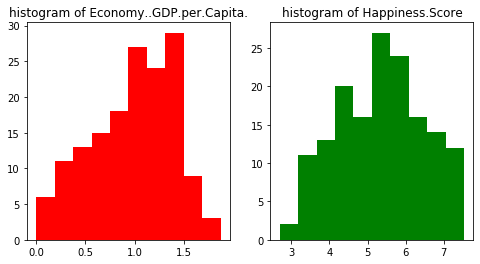

In [10]:
#@title run the code below for loading and auditing the data

# load and audit the dataset
inputs, outputs = loadData(filePath, featureNames, outputName)
inputs = fromStringToNumericData(inputs)
outputs = fromStringToNumericData(outputs)

# see how the data looks (plot the histograms associated to input data - temperature - and output data - no bikes)
plotHistograms(inputs, outputs)

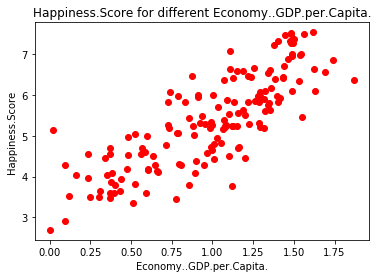

In [5]:
#@title run the code below to check the relationship betwwen input and output data

# check the relationship (to check that a linear relationship exists between the dependent variable (y = no bikes) and the independent variable (x = temp).)
plotData(inputs, outputs, featureNames, outputName)

### Antrenarea unui model de predictie - bazat pe arbori de decizie

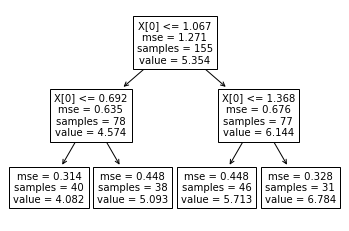

prediction training error:   0.3897527496121441


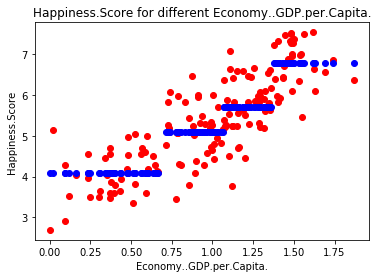

In [6]:
#@title run the code below for training the regressor; the training error will be printed

# learning step: init and train a tree-based regression model 

# model initialisation
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=2)

# training the model by using the training inputs and known training outputs
regressor.fit(inputs, outputs)

# visualise the trained model 
# visualiseRegressor(regressor)
plotADecisionTree(regressor)

computedOutputs = regressor.predict(inputs)
error = mean_squared_error(outputs, computedOutputs)
print('prediction training error:  ', error)
plotDataWithPredictions(inputs, outputs, computedOutputs, featureNames, outputName)

### Antrenarea unui model de predictie - bazat pe regresie

In [7]:
#@title run the code below for training the regressor; the training error will be printed

# learning step: init and train a linear regression model y = f(happiness) = w0 + w1 * GDP

# model initialisation
regressor = linear_model.
regressor = linear_model.LinearRegression()
regressor = linear_model.SGDRegressor()


# training the model by using the training inputs and known training outputs
regressor.fit(inputs, outputs)

# visualise the trained model 
visualiseRegressor(regressor)

# plot the learnt model
if (noFeatures == 1):
    plotRegressor(regressor, inputs, outputs)
else:
    print('to many dimensions...')

computedOutputs = regressor.predict(inputs)
error = mean_squared_error(outputs, computedOutputs)
print('prediction training error:  ', error)
plotDataWithPredictions(inputs, outputs, computedOutputs, featureNames, outputName)

SyntaxError: invalid syntax (Temp/ipykernel_3988/3318907797.py, line 6)

### Utilizarea unui model de predictie

In [ ]:
#@title run the code below for predicting the happiness score for some particular GDP values

# use case: a model for predicting the happiness based on the GDP
testData = [[1.1], [1.5], [1.3]]

print('for a GDP value of ', testData[0], ' the predicted happiness scor is: ', regressor.predict(testData)[0])
print('for a GDP value of ', testData[1], ' the predicted happiness scor is: ', regressor.predict(testData)[1])
print('for a GDP value of ', testData[2], ' the predicted happiness scor is: ', regressor.predict(testData)[2])

for a GDP value of  [1.1]  the predicted happiness scor is:  5.605816123670838
for a GDP value of  [1.5]  the predicted happiness scor is:  6.479490102210711
for a GDP value of  [1.3]  the predicted happiness scor is:  6.042653112940775


## Scenariul 2: predictia numarului de biciclete inchiriate pe baza unor factori diversi precum temperatura, viteza vantului, ziua din saptamana, etc.

Proces:
- Se pleaca de la un set de date format din date diverse despre numarul de biciclete inchiriate
- Se stabilesc variabile independente (temperatura, viteza vantului, ziua din saptamana) si dependente (nr de biciclete)
- Se aplica algoritmul de invatare pe setul de date de antrenament
- Se realizeaza predictii ale numarul de biciclete pe baza unuia sau unora dintre factorii de influenta

In [ ]:
#@title run the code below to inspect the raw data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/hour.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

dataCrt = pd.read_csv(filePath)
dataCrt.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Specificarea problemei 

- date de intrare: viteza vantului
- date de iesire: nr de biciclete

In [ ]:
#@title run the code below for setting the input data and the output data

# first use case: a model for predicting the no of bikes based on the wind speed
noFeatures = 1
featureNames = ['windspeed']
outputName = 'cnt'


### Incarcarea si auditarea datelor

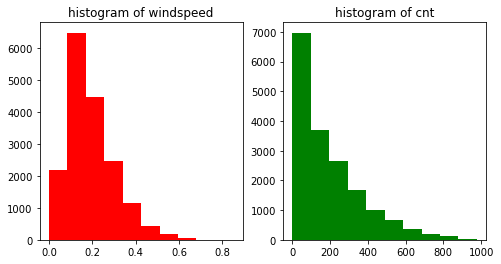

In [ ]:
#@title run the code below for loading and auditing the data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/hour.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

# load and audit the dataset
inputs, outputs = loadData(filePath, featureNames, outputName)
inputs = fromStringToNumericData(inputs)
outputs = fromStringToNumericData(outputs)

# see how the data looks (plot the histograms associated to input data - temperature - and output data - no bikes)
plotHistograms(inputs, outputs)

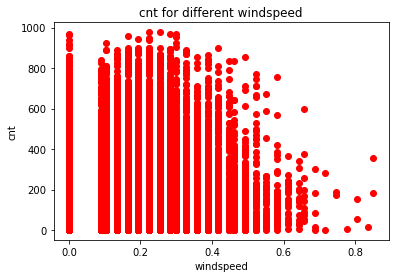

In [ ]:
#@title run the code below to check the relationship betwwen input and output data

# check the relationship (to check that a linear relationship exists between the dependent variable (y = no bikes) and the independent variable (x = temp).)
plotData(inputs, outputs, featureNames, outputName)

### Antrenarea unui model de predictie

the learnt model: f(x) = 163.1853323629292 + 138.2329624351456 * x^1


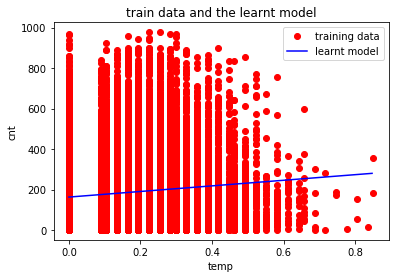

prediction training error:   32613.58717115028


In [ ]:
#@title run the code below for training the regressor; the training error will be printed

# learning step: init and train a linear regression model y = f(noBikes) = w0 + w1 * windspeed

# model initialisation
regressor2 = linear_model.LinearRegression()

# training the model by using the training inputs and known training outputs
regressor2.fit(inputs, outputs)

# visualise the trained model 
visualiseRegressor(regressor2)

# plot the learnt model
if (noFeatures == 1):
    plotRegressor(regressor2, inputs, outputs)
else:
    print('to many dimensions...')

computedOutputs = regressor2.predict(inputs)
error = mean_squared_error(outputs, computedOutputs)
print('prediction training error:  ', error)

### Utilizarea unui model de predictie

In [ ]:
#@title run the code below for predicting the happiness score for some particular windspeed values

# predict the number of bikes for a set of new 3 windspeed
testData = [[0.3284], [0.2985], [0.3015]]

print('for a wind speed of ', testData[0], ' the predicted no bikes is: ', regressor.predict(testData)[0])
print('for a wind speed of ', testData[1], ' the predicted no bikes is: ', regressor.predict(testData)[1])
print('for a wind speed of ', testData[2], ' the predicted no bikes is: ', regressor.predict(testData)[2])

for a wind speed of  [0.3284]  the predicted no bikes is:  3.9204990190674236
for a wind speed of  [0.2985]  the predicted no bikes is:  3.855191889171568
for a wind speed of  [0.3015]  the predicted no bikes is:  3.861744444010617


## Scenariul 3: predictia numarului de biciclete inchiriate pe baza unor factori diversi precum temperatura, viteza vantului, ziua din saptamana, etc.

Proces:
- Se pleaca de la un set de date format din date diverse despre numarul de biciclete inchiriate
- Se stabilesc variabile independente (temperatura, viteza vantului, ziua din saptamana) si dependente (nr de biciclete)
- Se aplica algoritmul de invatare pe setul de date de antrenament
- Se realizeaza predictii ale numarul de biciclete pe baza unuia sau unora dintre factorii de influenta

In [ ]:
#@title run the code below to inspect the raw data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/hour.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

dataCrt = pd.read_csv(filePath)
dataCrt.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Specificarea problemei 

- date de intrare: viteza vantului, temperatura
- date de iesire: nr de biciclete

In [ ]:
#@title run the code below for setting the input data and the output data

# second use case: a model for predicting the no of bikes based on the temperature and the wind speed
noFeatures = 2
featureNames = ['atemp', 'windspeed']
outputName = 'cnt'

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/hour.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

### Incarcarea si auditarea datelor

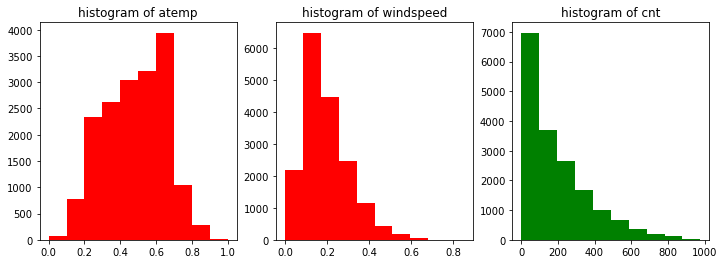

In [ ]:
#@title run the code below for loading and auditing the data

# load and audit the dataset
inputs, outputs = loadData(filePath, featureNames, outputName)
inputs = fromStringToNumericData(inputs)
outputs = fromStringToNumericData(outputs)

# see how the data looks (plot the histograms associated to input data - temperature - and output data - no bikes)
plotHistograms(inputs, outputs)

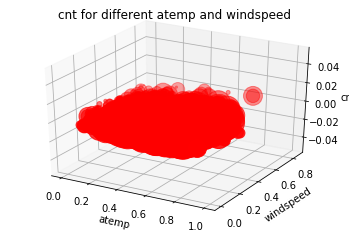

In [ ]:
#@title run the code below to check the relationship between input and output data

# check the relationship (to check that a linear relationship exists between the dependent variable (y = no bikes) and the independent variable (x = temp).)
plotData(inputs, outputs, featureNames, outputName)

### Antrenarea unui model de predictie

In [ ]:
#@title run the code below for training the regressor; the training error will be printed

# learning step: init and train a linear regression model y = f(noBikes) = w0 + w1 * windspeed

# model initialisation
from sklearn import linear_model 

# regressor3 = linear_model.LinearRegression()
regressor3 = linear_model.SGDRegressor()

# training the model by using the training inputs and known training outputs
regressor3.fit(inputs, outputs)

# visualise the trained model 
visualiseRegressor(regressor3)

# plot the learnt model
if (noFeatures == 1):
    plotRegressor(regressor3, inputs, outputs)
else:
    print('to many dimensions...')

computedOutputs = regressor3.predict(inputs)
error = mean_squared_error(outputs, computedOutputs)
print('prediction training error:  ', error)

the learnt model: f(x) = -49.042662583702196 + 430.98927403134445 * x^1 + 175.97162319354334 * x^2
to many dimensions...
prediction training error:   27149.50482688288


### Utilizarea unui model de predictie

In [ ]:
#@title run the code below for predicting the happiness score for some particular temperature and windspeed values

# predict the number of bikes for a set of new 3 tempeatures and 3 windspeeds 
testData = [[0.33, 0.3284], [0.46, 0.2985], [0.42, 0.3015]]

print('for temp and windspeed values of ', testData[0], ' the predicted no bikes is: ;', regressor3.predict(testData)[0])
print('for temp and windspeed values of ', testData[1], ' the predicted no bikes is: ;', regressor3.predict(testData)[1])
print('for temp and windspeed values of ', testData[2], ' the predicted no bikes is: ;', regressor3.predict(testData)[2])

for temp and windspeed values of  [0.33, 0.3284]  the predicted no bikes is: ; 151.66045720222291
for temp and windspeed values of  [0.46, 0.2985]  the predicted no bikes is: ; 202.30470345974564
for temp and windspeed values of  [0.42, 0.3015]  the predicted no bikes is: ; 185.65785979652892
